# Twitter Sentmint Analyzer

 In this notebook, data will be loaded and preprocced then it will be trained on LSTM layers to analyse twitter sentment reasons 

 ## Contents 
 - [Required modules](#Required%modules)
 - [loading data](#loading%data)
 - [Data analysis](#Data%analysis)
 - [Data encoding](#Data%encoding)
 - [Data decoding](#Data%decoding)
 - [Match length and strat index ](#Match%length%and%strat%index)
 - [Data masking](#Data%masking)
 - [Un-Mask data](#Un-Mask%data)
 - [Preparing training and validation data](#Preparing%training%and%validation%data)
 - [Defining the model](#Defining%the%model)
 - [Model parameters count](#Model%parameters%count)
 - [Hyperparameter](#Hyperparameter)
 - [Instantiate model](#Instantiate%model)
 - [Test forward function](#Test%forward%function)
 - [Optimizer and criterion](#Optimizer%and%criterion)
 - [Train function](#Train%function)
 - [Saving model](#Saving%model)
 

### Required modules 

In [15]:
# jupyter majec function to print images inlined
%matplotlib inline 

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # ploting.
import seaborn as sns # more cool plotting 
from nltk.corpus import stopwords # load stoping words
from nltk.tokenize import word_tokenize # word tokenizer
import operator
from itertools import chain 
from math import floor
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 100

import re # Regular expression

### Loading data

In [2]:
dataPath = 'dataset'

#Training data
train = pd.read_csv(dataPath+'/train.csv')
# Testing data 
test = pd.read_csv(dataPath+'/test.csv')

for col in train.columns:
    train[col] = train[col].astype(str)
for col in test.columns:
    test[col] = test[col].astype(str)

print("Train data of shape",train.shape)
print("Test data of shape",test.shape)

Train data of shape (27486, 4)
Test data of shape (3535, 3)


In [3]:
# train data sample
elements_from_head=10 # number of elements to show from head

print("Train data first", elements_from_head, "samples")
train.head(elements_from_head)

Train data first 10 samples


,textID,text,selected_text,sentiment
0,a3d0a7d5ad,"Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning",my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! http://plurk.com/p/wxpdj,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive
5,1915bebcb3,headache wanna see my Julie,headache,negative
6,2ab82634d5,had an awsome salad! I recommend getting the Spicey buffalo chicken salad!,had an awsome salad!,positive
7,a5a1c996c0,fine! Going to do my big walk today 20 or so miles,fine!,positive
8,a182b2638e,Thank a yoou how are you? #TwitterTakeover,Thank,positive
9,1dcb6fdb13,Why don't adobe realise no one WANTS to pay for Photoshop et al so they should just give it to us for free,Why don't adobe realise no one WANTS to pay for Photoshop et al so they should just give it to us for free,neutral


In [4]:
# test data sample

print("Test data first", elements_from_head, "samples")
test.head(elements_from_head)

Test data first 10 samples


,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calling you but i can't from Malta,positive
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet,positive
2,2524332d66,I'm concerned for that family,positive
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have tooo many followers tho ...,positive
4,e6c9e5e3ab,26th February,neutral
5,311d2b185b,Tracy and Berwick breaks my achy breaky heart They split ways in the hallways.,negative
6,95dfefd4e7,Well off 2 bed...cant wait 2 party 4 Mother's Day in like 14 hours or so,positive
7,739f17cfe1,Oh yeah the camera clipping problems with Void are now completely fixed yay me for fiddling about,positive
8,c6322a85c2,_Layne hmm.. what's ur fav movie?? tv shows??,neutral
9,b4401d6b4d,"salt and vinegar, cheese and onion make your breathe smell lol ****",negative


### Data analysis 

Training data
Number of positive is 11118, number of negative is 8582, and number of neutral is 7786
Train Data Sentiment


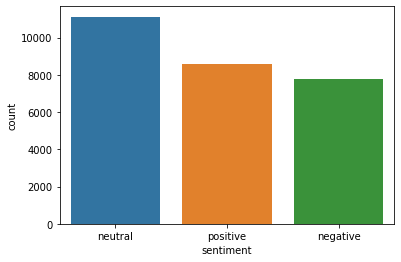

In [5]:
pos,neg,nat=train['sentiment'].value_counts()

print("Training data")
print("Number of positive is {}, number of negative is {}, and number of neutral is {}".format(pos,neg,nat))
sns.countplot(x='sentiment',data=train)
print("Train Data Sentiment")

In [6]:
def word_frequency(data,return_word_frequency):
    for word in data.split():
        if return_word_frequency.get(word, False): return_word_frequency[word]+=1
        else: return_word_frequency[word]=1
    return return_word_frequency


train_text_freq={}
for i in train.text:
    train_count_freq = word_frequency(i,train_text_freq)
    
# train_text_freq = train_df.text.apply(lambda x : word_frequency(x,train_text_freq) )

sorted_train_text_freq = sorted(train_text_freq.items(), key=operator.itemgetter(1))
print(sorted_train_text_freq[-11:-1])

[('in', 3556), ('for', 3575), ('is', 3670), ('you', 3808), ('i', 4264), ('and', 4677), ('my', 4932), ('a', 6503), ('the', 8391), ('I', 8802)]


### Data encoding 

Character one hot encodings 

In [ ]:
oneHotBase=np.zeros(256)

def oneHot(i):
    cop=np.copy(oneHotBase)
    cop[i]=1
    return cop 
chr2vec={chr(i): oneHot(i) for i in range(256)}


def encode(text):
    ln = len(text)
    a= np.fromiter(chain.from_iterable(chr2vec[text[x2]] for x2 in range(len(text))), 'i', len(text) * 256)
    a.shape = len(text), 256
#   a= np.empty((ln, 256), int) # (text, 265)
#   for i in range(ln):
#       a[i]=chr2vec[text[i]]
#       [chr2vec[text[i]] for i in range(ln)]
    x = np.zeros((280-len(text),256)) #(text,256)
    
    return np.concatenate((a, x), axis=0)


train_encoded=train.copy()
train_encoded.text=train.text.apply(lambda x:encode(x))
train_encoded.selected_text=train.selected_text.apply(lambda x:encode(x))


test_encoded=test.copy()
test_encoded.text=test.text.apply(lambda x:encode(x))

print("Finished encoding")
train_encoded.head()
    

### Data decoding

In [ ]:
def vec2Chr(lst):
    for x in range(len(lst)): 
        if lst[x] == 1: return chr(x)

def vecs2String(lst):
    string=""
    for i in lst:
        if i == oneHotBase: break
        string+=vec2Chr(i)
    return string

print("Decode(train_encoded.text[0]) is: \n",vecs2String(train_encoded.text[0]))
print("=================")


do_assert = 1
if do_assert:
    assert(vec2Chr(chr2vec['a']) == 'a') 
    assert(vecs2String(train_encoded.text[0]) == train.text[0]) 
    
print("Finished decoding")

### Match length and strat index 

In [7]:
train["match_length"]=train.apply(lambda x : len(x.selected_text), axis=1)
train["start_index"]=train.apply(lambda x : x.text.find(x.selected_text), axis=1)

print("Done match_length Calc.")
train.head()

Done match_length Calc.


,textID,text,selected_text,sentiment,match_length,start_index
0,a3d0a7d5ad,"Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning",my boss was not happy w/ them. Lots of fun.,neutral,43,55
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,4,5
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! http://plurk.com/p/wxpdj,says good (or should i say bad?) afternoon!,neutral,43,0
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,34,1
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,6,6


### Data masking

In [8]:
def mask(original, subtext, match_length, start_index):
    msk=np.zeros(len(original))
    msk[start_index:start_index+match_length]+=1
    return msk

def padding(lst):
    return np.append(lst, np.array([0]*(280-len(lst))))
    
masks = (train.apply(lambda x : mask(x.text, x.selected_text, x.match_length, x.start_index), axis=1)).apply(
        lambda x : padding(x))
train["masks"]=masks
train.head()

,textID,text,selected_text,sentiment,match_length,start_index,masks
0,a3d0a7d5ad,"Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning",my boss was not happy w/ them. Lots of fun.,neutral,43,55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...]"
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! http://plurk.com/p/wxpdj,says good (or should i say bad?) afternoon!,neutral,43,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,34,1,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,6,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"


### Un-Mask data

In [ ]:
def un_mask(string, mask): 
    return ''.join([string[i] for i in range(len(mask)) if int(mask[i]) == 1])

un_masked = train.apply(lambda x: un_mask(x.text,x.masks), axis=1)

### Preparing training and validation data

In [12]:
validation_data_size= floor(train.shape[0])*(10/100)
idx= (np.random.default_rng()).choice(train.shape(0), size=validation_data_size, replace=False)
validation_data= train[idx]

train.drop(idx)

AttributeError: module 'numpy.random' has no attribute 'default_rng'

### Defining the model

In [17]:
class Network(nn.Module):
    def __init__(self, input_size, LSTM_hidden_size, LTSM_num_layers, hidden_layers,
                 LSTM_dropout, batch_first=True, output_size=1, drop_p=0.5):
        
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = LSTM_hidden_size,
                            num_layers = LTSM_num_layers,
                            batch_first = batch_first,
                            dropout = LSTM_dropout,
                            bidirectional=True)
        
        
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(LSTM_hidden_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # 
        x = F.tanh(self.lstm(x))

        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


### Model parameters count

In [18]:
'''
input_size, LSTM_hidden_size, LTSM_num_layers, hidden_layers,
LSTM_dropout, batch_first=True, output_size=1, drop_p=0.5)
'''
model_1 = Network(256, 256, 2, [256,150,50],
               0.1, True, 1, 0.2)

model_2 = Network(256, 256, 1, [256,150,50],
               0.1, True, 1, 0.2)

model_3 = Network(256, 256, 1, [256,50],
               0.1, True, 1, 0.2)

model_4 = Network(256, 100, 1, [100,50,25],
               0.1, True, 1, 0.2)

model_5 = Network(256, 100, 2, [100,50,25],
               0.1, True, 1, 0.2)

model_6 = Network(256, 200, 2, [100,50,25],
               0.1, True, 1, 0.2)

model_7 = Network(256, 200, 2, [100,50,25],
               0.9, True, 1, 0.9)

model_8 = Network(256, 256, 3, [100,50,25],
               0.9, True, 1, 0.9)

model_9 = Network(256, 256, 4, [100,50,25],
               0.9, True, 1, 0.9)

model_10 = Network(256, 256, 5, [100,50,25],
               0.9, True, 1, 0.9)

print("Trainable parameters for model_1 is ", sum(p.numel() for p in model_1.parameters() if p.requires_grad))
print("Trainable parameters for model_2 is ", sum(p.numel() for p in model_2.parameters() if p.requires_grad))
print("Trainable parameters for model_3 is ", sum(p.numel() for p in model_3.parameters() if p.requires_grad))
print("Trainable parameters for model_4 is ", sum(p.numel() for p in model_4.parameters() if p.requires_grad))
print("Trainable parameters for model_5 is ", sum(p.numel() for p in model_5.parameters() if p.requires_grad))
print("Trainable parameters for model_6 is ", sum(p.numel() for p in model_6.parameters() if p.requires_grad))
print("Trainable parameters for model_7 is ", sum(p.numel() for p in model_7.parameters() if p.requires_grad))
print("Trainable parameters for model_8 is ", sum(p.numel() for p in model_8.parameters() if p.requires_grad))
print("Trainable parameters for model_9 is ", sum(p.numel() for p in model_9.parameters() if p.requires_grad))
print("Trainable parameters for model_10 is ", sum(p.numel() for p in model_10.parameters() if p.requires_grad))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Trainable parameters for model_1 is  2741575
Trainable parameters for model_2 is  1164615
Trainable parameters for model_3 is  1131365
Trainable parameters for model_4 is  302851
Trainable parameters for model_5 is  544451
Trainable parameters for model_6 is  1722451
Trainable parameters for model_7 is  1722451
Trainable parameters for model_8 is  4238643
Trainable parameters for model_9 is  5815603
Trainable parameters for model_10 is  7392563


### Hyperparameter

In [19]:
learning_rate=0.1
input_size= 256
LSTM_hidden_size= 256
LTSM_num_layers= 2
hidden_layers= [256,150,50]
LSTM_dropout= 0.1
batch_first=True
output_size=1
drop_p=0.5

### Instantiate model

In [20]:
model = Network(input_size, LSTM_hidden_size, LTSM_num_layers, hidden_layers, LSTM_dropout,
                batch_first, output_size, drop_p)

### Test forward function

### Optimizer and criterion

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train function

In [22]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for tweet, result in trainloader:
            steps += 1
            
    
            optimizer.zero_grad()
            
            output = model.forward(tweet)
            loss = criterion(output, results)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

### Saving model

In [23]:
torch.save(model.state_dict(), 'checkpoint.pth')